<a href="https://colab.research.google.com/github/josedv82/NBA_Predictive_Model/blob/main/NBA_Schedule_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[XGBOOST](https://xgboost.readthedocs.io/en/latest/) PLAYGROUND**


---


## **Game Outcome Prediction Model Based on NBA Schedule Data**  
### Jose Fernandez
  

##### Open on [Github](https://github.com/josedv82/NBA_Predictive_Model/blob/main/NBA_Schedule_xgboost.ipynb)




---



#1. Prepare packages and data

Load packages and split the dataset into train and test set for h2o

In [1]:
#install required packages
suppressMessages(
  install.packages(c("tidyverse", "h2o", "ggtext"))
)

We are loading 20 seasons worth of games. I won't do any EDA here since I am familiar with this from previous work. For those interested, I created a game [schedule density application](https://josedv.shinyapps.io/NBASchedule/) that helps users explore schedule data in different way. 

```Note: add EDA here in the future as part of this demo ```

In [ ]:
#load libraries and data
library(tidyverse)
library(h2o)


#20 seasons (2000-2019). The raw data was downloaded using the airball package in R. In addition, other metrics were calculated based on the raw data
#in this case the data is perfectly balanced, since each game provides two observations (winning and losing)
dat <- read.csv("https://www.dropbox.com/s/638fwmfr4o2q864/data_nba_sche.csv?dl=1") %>%
mutate(Result = as.factor(Result))

str(dat)

#for more info on how this data was collected visit: https://github.com/josedv82/airball


Initialize the h2o cluster:

In [ ]:
#start h2o cluster
suppressWarnings(h2o.init())

Next we will set the target (game results) and features of our model.

In [4]:
#set target and features
target <- "Result"

#set predictors - removed features accounting for long (>10 days) periods
features <- setdiff(colnames(dat), 
c(target, "Season", "Team", "Opponent", "Date", "G11", "G13", "G15", "G17", "G19", "G21", 
          "Opp_G11", "Opp_G13", "Opp_G15", "Opp_G17", "Opp_G19", "Opp_G21"))
print(features) 

#all features used in the model accounting for multiple metrics for the team as well as the opponent for each game

# Distance Features: Cum distance travelled over different time windows 3d, 5d, etc..
# Shift Features: Sum of shifts (time zone changes) over different time windows 3d, 5d, etc...
# G Features: Sum of games played over different time windows 3d, 5d, etc...
# Rest: Number of rest days for a given day
# Zone: Time zone change for a given day
# Features starting with "Opp" refer to same metrics for opponents
# win_pct: win_pct for a given game

 [1] "Location"      "Distance"      "Distance3"     "Distance5"    
 [5] "Distance7"     "Distance9"     "Rest"          "Zone"         
 [9] "G3"            "G5"            "G7"            "G9"           
[13] "Shift3"        "Shift5"        "Shift7"        "Shift9"       
[17] "win_pct"       "Opp_Distance"  "Opp_Rest"      "Opp_Zone"     
[21] "Opp_G3"        "Opp_G5"        "Opp_G7"        "Opp_G9"       
[25] "Opp_Shift3"    "Opp_Shift5"    "Opp_Shift7"    "Opp_Shift9"   
[29] "Opp_Distance3" "Opp_Distance5" "Opp_Distance7" "Opp_Distance9"
[33] "opp_win_pct"  


Create train, validation and testing data

In [5]:
#convert our df into a h2o df
suppressWarnings(
  h_data <- as.h2o(dat)
  )
# split 70/15/15 train/validation and test dataset
h_split <- h2o.splitFrame(h_data, ratios = c(0.7, 0.15), seed = 42)
h_train <- h_split[[1]]
h_valid <- h_split[[2]]
h_test <- h_split[[3]]


  |======================================================================| 100%




---



#2. Model Hyperparameters
To help define the best parameters for our model, we can run a search to identify best model performance based on AUC. We'll search over as many models as possible during x number of seconds. This will help set up the model. 

*Only Run this part if you wish to explore other model parameters. The actual model I built below is already set*

In [ ]:
#create a grid of different parameters ranges. Will keep it simple for now to only a few parameters.
xgb_params <- list(learn_rate = seq(0.1, 0.3, 0.01), 
                   max_depth = seq(2, 10, 1),
                   subsample = seq(0.9, 1.0, 0.05),
                   col_sample_rate = seq(0.1, 1.0, 0.1))

#searching criteria. As many models as can be trained in x number of seconds (set for 10mins right now)
search_criteria <- list(strategy = "RandomDiscrete", max_runtime_secs = 600) 

#create the grid
xgb_grid <- h2o.grid("xgboost", x = features, y = target,
                      grid_id = "xgb_grid",
                      training_frame = h_train,
                      validation_frame = h_valid,
                      ntrees = 500, 
                      seed = 42,
                      hyper_params = xgb_params,
                      search_criteria = search_criteria)

#display the top models based on AUC
xgb_gridperf <- h2o.getGrid(grid_id = "xgb_grid", 
                             sort_by = "auc", 
                             decreasing = TRUE)
print(xgb_gridperf)

Check the best model on unseen data

In [ ]:
# Get the model id for the best identified model
best_xgb_model_id <- xgb_gridperf@model_ids[[1]]
best_xgb <- h2o.getModel(best_xgb_model_id)

# Evaluate model performance on unseen data for confirmation
best_xgb_perf <- h2o.performance(model = best_xgb, 
                                 newdata = h_test) 

paste("AUC:", round(h2o.auc(best_xgb_perf),3))



---



#3. Build the model

Creating the XGBoost model using the parameters from the best model detected on the previous step.

In [ ]:
# Build and train the xgboost model using the parameters from the best model identifies on previous step 
mod_xgb <- h2o.xgboost(x = features, y = target,
                           training_frame = h_train, 
                           validation_frame = h_valid,
                           booster = "gbtree",
                           #nfolds = 5,
                           eta = 0.11, 
                           max_depth = 2, 
                           gamma = 2,
                           subsample = 0.95,
                           ntrees = 500,
                           stopping_rounds = 1,
                           stopping_metric = "logloss",
                           seed = 42)



---



#4. Model Performance

Below are a few ways to look at the performance of this model.  
*AUC 0.8 | Accuracy 0.72*

In [7]:
# Model Performance
perf <- h2o.performance(mod_xgb, h_valid)
perf

#max f1 threshold (from valid dataset) at 0.40. Anything above that will be predicted as 1 (win)

H2OBinomialMetrics: xgboost

MSE:  0.1817086
RMSE:  0.4262729
LogLoss:  0.5372873
Mean Per-Class Error:  0.2823526
AUC:  0.801276
AUCPR:  0.8039467
Gini:  0.602552
R^2:  0.2731602

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
          0    1    Error        Rate
0      2364 1466 0.382768  =1466/3830
1       693 3116 0.181938   =693/3809
Totals 3057 4582 0.282629  =2159/7639

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.408585    0.742701 238
2                       max f2  0.164267    0.846749 343
3                 max f0point5  0.572548    0.736584 166
4                 max accuracy  0.544487    0.727189 178
5                max precision  0.999810    1.000000   0
6                   max recall  0.009235    1.000000 396
7              max specificity  0.999810    1.000000   0
8             max absolute_mcc  0.544487    0.456400 178
9   max 

Plot the AUC curve on the unseen data

[1] "AUC: 0.801"


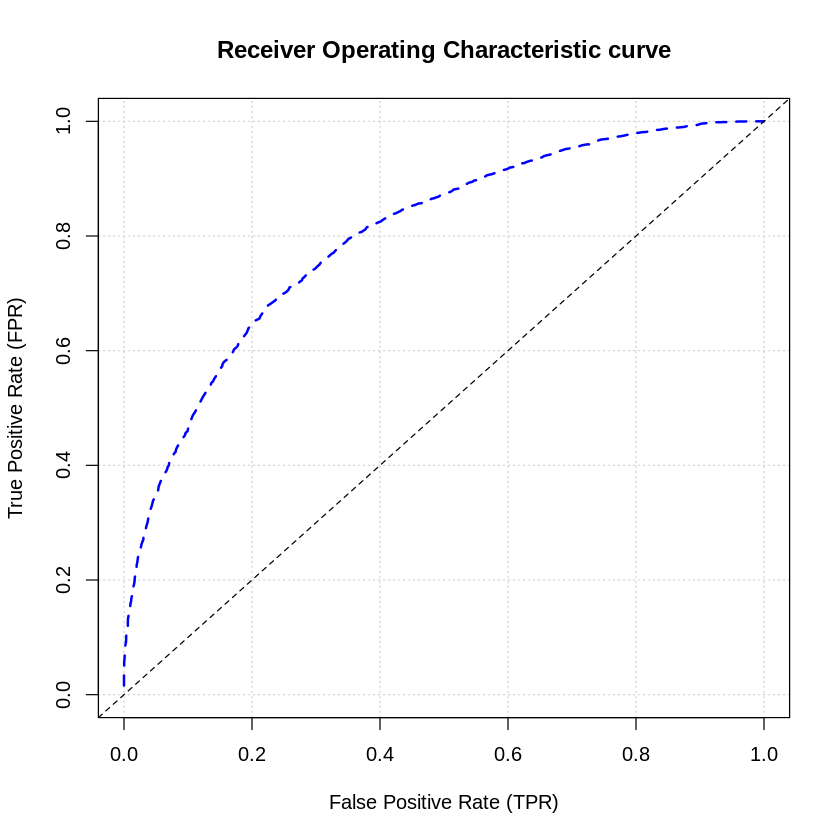

In [8]:
# retrieve the AUC for the performance object:
print(paste("AUC:", round(h2o.auc(perf),3)))
plot(perf, type = "roc")

AUC comparison on training and validation datasets.

In [ ]:
# retrieve the AUC for both the training and validation data:
round(h2o.auc(mod_xgb, train = TRUE, valid = TRUE, xval = FALSE),3)

train valid 
0.809 0.801

Checking predictions from our model on unseen data. Every time this code is ran it will output a table of 20 random games, displaying tha actual result of the game, the binary prediction of the model as well as the probability associated with winning an losing for each game.

To predict a win, the probability of winning has to be above the f1 threshold of 0.4.

In [ ]:
# Generate predictions on unseen data
pred <- h2o.predict(mod_xgb, newdata = h_test)

# add team columns to predictions
preds <- as.data.frame(pred) %>% 
mutate(ID = row_number()) %>% 
select(ID, `Predicted Result` = predict, `Probability_0` = p0, `Probability_1` = p1)

test_dat <- as.data.frame(h_test) %>% 
select(Season, Date, Team, Opponent, Location, `Actual Result` = Result) %>% 
mutate(Location = ifelse(Location == 0, "Home", "Away")) %>%
mutate(ID = row_number())

tab <- full_join(test_dat, preds, by = "ID") %>% 
select(-ID) %>%
mutate(Guess = ifelse(`Actual Result` == `Predicted Result`, "Correct", "Wrong"),
       Probability_0 = round(Probability_0, 2),
       Probability_1 = round(Probability_1, 2))

# sample 20 games at random
tab[sample(nrow(tab), 20), ]

  |======================================================================| 100%


,Season,Date,Team,Opponent,Location,Actual Result,Predicted Result,Probability_0,Probability_1,Guess
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<chr>
2110,2004-05,2/15/2005,New Jersey Nets,Minnesota Timberwolves,Away,0,0,0.66,0.34,Correct
3452,2008-09,2/8/2009,Boston Celtics,San Antonio Spurs,Home,0,1,0.33,0.67,Wrong
3679,2008-09,3/13/2009,New Jersey Nets,Portland Trail Blazers,Away,0,0,0.86,0.14,Correct
7486,2018-19,2/22/2019,Detroit Pistons,Atlanta Hawks,Away,1,1,0.40,0.60,Correct
7459,2018-19,4/7/2019,Dallas Mavericks,Memphis Grizzlies,Away,1,0,0.63,0.37,Wrong
1283,2002-03,2/5/2003,Los Angeles Clippers,Detroit Pistons,Away,0,0,0.88,0.12,Correct
5555,2013-14,3/3/2014,Miami Heat,Charlotte Bobcats,Home,1,1,0.13,0.87,Correct
5258,2012-13,4/4/2013,Oklahoma City Thunder,San Antonio Spurs,Home,1,1,0.32,0.68,Correct
2699,2006-07,5/17/2007,Chicago Bulls,Detroit Pistons,Home,0,1,0.42,0.58,Wrong




---



#5. Model Explainability with SHAP values

Since this is a blackbox model, it is important to find ways to explain the outcome so that the users of this model can make changes related to the features we are accounting for. For example, if we know that distance traveled in the last 7 days is important, we may try and optimise our travel options.

[SHAP Values](https://www.kaggle.com/dansbecker/shap-values) (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Shap values not only show the contribution of each future but also in which direction it influence the model outcome. In this case, blue contributes towards losing, while pink contributes towards winning.

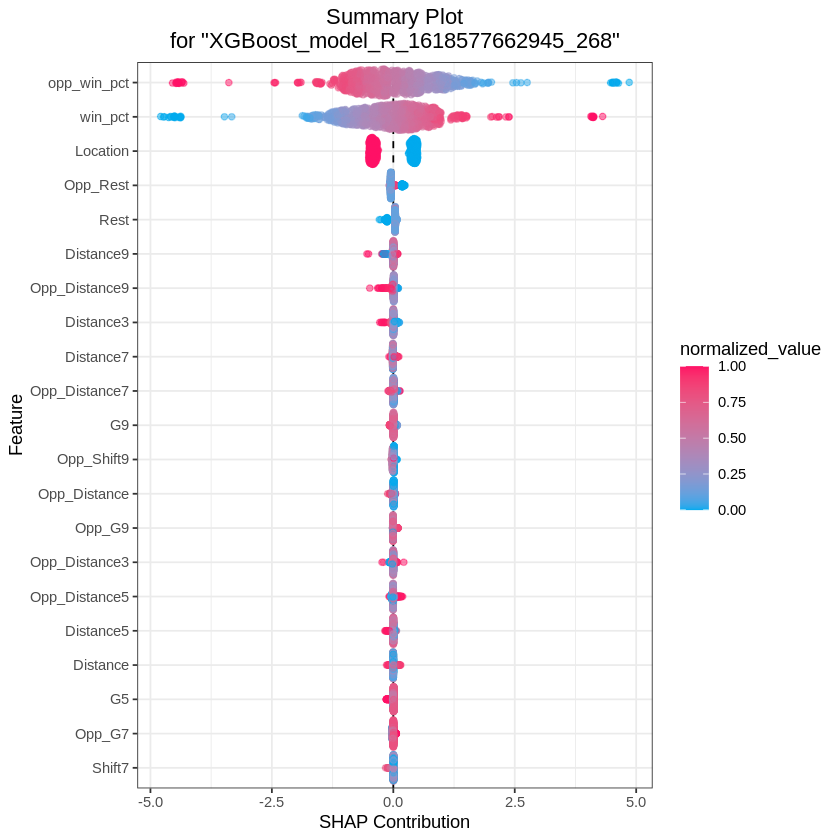

In [ ]:
#shap explanation for the model. at the top more important features. Pink colors contribute to winning
shap_summary_plot <- h2o.shap_summary_plot(mod_xgb, h_test)
print(shap_summary_plot)

#Not surprising, Opp_Win_Pct, win_pct, game location and Rest for both the team and the opponent are the most important features.

## Explaining individual observations (games)

We can use SHAP values to understand how the model makes a decision on winning or losing for each different game. The plot below shows the magnitude and direction of the contribution of each feature towards the game outcome prediction.

*Re-run this plot to show another random game from the test dataset.*

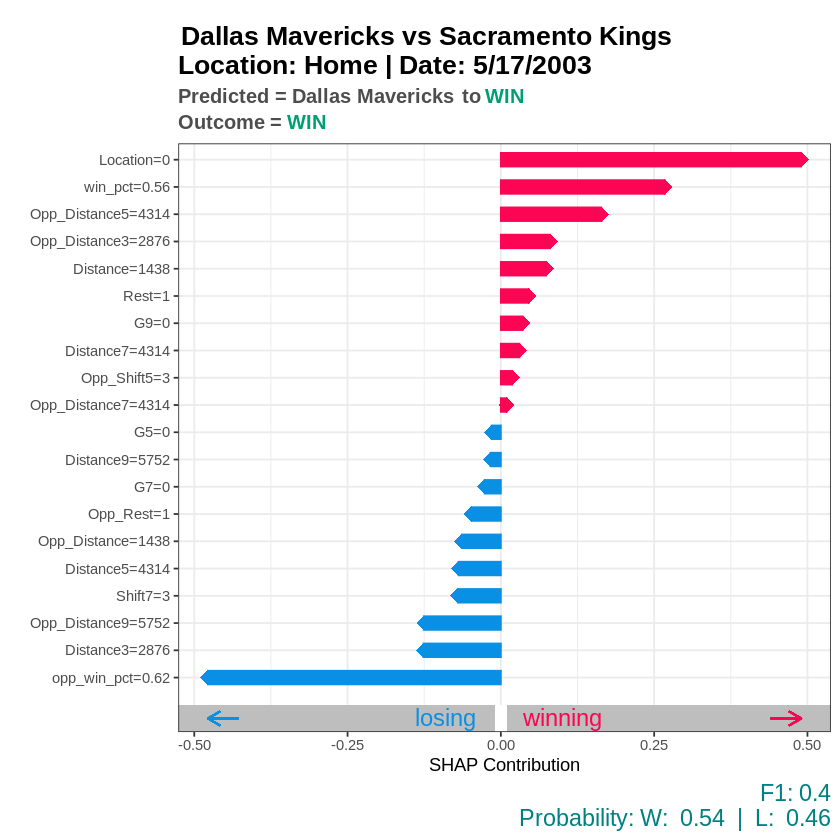

In [ ]:
#shap (force plot) explanation for one observation o the test data. Change row index between 0-7777 to pick another game

#parameters for plot
row_index <- sample(0:7777, 1) #sample random game from the test dataset every time this chunk is run
df <- as.data.frame(h_test[row_index,])
probs <- tab[row_index,]
Team <- df$Team
Opponent <- df$Opponent
Location <- if (df$Location == 1) {"Away"} else {"Home"}
Date <- df$Date
Result <- if (df$Result == 0) {"<span style='color:darkred;'>LOSS</span>"} else {"<span style='color:#009E73;'>WIN</span>"}

#shap plot object
shap_ind_row <- h2o.shap_explain_row_plot(mod_xgb, h_test, row_index = row_index) # on test dataset

#extract prediction (0 or 1)
Prediction <- if (sub(".*: ", "", shap_ind_row$labels$title) == "0") {"<span style='color:darkred;'>LOSE</span>"} else {"<span style='color:#009E73;'>WIN</span>"}
shap_ind_row$layers[[1]]$aes_params$fill <- NULL

#enhance the final shap force plot
shap_ind_row +
annotate("rect", ymin = -Inf, ymax = Inf, xmin = -1, xmax = 0, fill = "grey") +
annotate("rect", ymin = -0.01, ymax = 0.01, xmin = -1, xmax = 0, fill = "white") +
annotate("text", y = 0.1, x = -0.45, label = "winning", color = "#fc0555", size = 5) +
annotate("text", y = -0.09, x = -0.45, label = "losing", color = "#0990e5", size = 5) +
annotate("text", y = 0, x = -1, label = ".", color = "white") +
aes(fill = contribution < 0, color = contribution < 0, width = 0.5) + 
geom_point(shape = 18, size = 4) +
scale_fill_manual(values = c("TRUE" = "#0990e5", "FALSE" = "#fc0555")) +
geom_segment(aes(x = -0.5, y = max(contribution) - 0.05, xend = -0.5, yend = max(contribution)), arrow = arrow(length = unit(0.3, "cm")), color = "#fc0555") +
geom_segment(aes(x = -0.5, y = min(contribution) + 0.05, xend = -0.5, yend = min(contribution)), arrow = arrow(length = unit(0.3, "cm")), color = "#0990e5") +
scale_color_manual(values = c("TRUE" = "#0990e5", "FALSE" = "#fc0555")) +
labs(title = paste("", Team, "vs", Opponent, "\n", "Location:", Location, "| Date:", Date, sep = " "),
     subtitle = paste("Predicted =", df$Team, "to ", Prediction, "<br>", "Outcome = ", Result),
     caption = paste("F1: 0.4\n","Probability:", "W: ", probs$Probability_1, " | ", "L: ", probs$Probability_0),
     x = "") +
theme(plot.title = element_text(size = 16, hjust = -0.03, face = "bold"),
      plot.subtitle = ggtext::element_markdown(size = 12, lineheight = 1.3, face = "bold", color = "grey30"),
      plot.caption = element_text(size = 14, color = "#008080"),
      legend.position = "none")



---



# 6. Predictions on 2021 Season

Our model was trained with data from the 2000-19 seasons. Here we will run it on 2021 data. 

The following code outputs a table with predictions for the 2021 games that have been played as well as the remaining ones (as of 4/6/21).

*Use the filter on the right to view the 2021 predictions for specific teams.*

In [ ]:
#@title Select a team { run: "auto", form-width: "20%" }
Team1 <- "Utah Jazz" #@param ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets", "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors", "Utah Jazz", "Washington Wizards"]

#load 2021 season data downloaded from Airball package
dat21 <- read.csv("https://www.dropbox.com/s/72qx6zvp8ieak25/data_nba_sche_2021.csv?dl=1") %>% mutate(ID = row_number())

#remove columns not used for modeling
dat21_mod <- dat21 %>% select(-Season, -Team, -Opponent, -Date, -G11, -G13, -G15, -G17, -G19, -G21, -Opp_G11, -Opp_G13, -Opp_G15, -Opp_G17, -Opp_G19, -Opp_G21)

h_dat21_mod <- suppressWarnings(as.h2o(dat21_mod))

# Generate predictions on unseen data
pred21 <- h2o.predict(mod_xgb, newdata = h_dat21_mod)

# add games columns fro daw data set to predictions
preds21 <- as.data.frame(pred21) %>% 
mutate(ID = row_number()) %>% 
select(ID, `Predicted Result` = predict, `Probability_0` = p0, `Probability_1` = p1)

test_dat <- dat21 %>% 
select(Season, Date, Team, Opponent, Location, `Actual Result` = Result) %>% 
mutate(Location = ifelse(Location == 0, "Home", "Away")) %>%
mutate(ID = row_number())

tab <- full_join(test_dat, preds21, by = "ID") %>% 
select(-ID) %>%
mutate(Guess = ifelse(`Actual Result` == `Predicted Result`, "Correct", "Wrong"),
       Probability_0 = round(Probability_0, 2),
       Probability_1 = round(Probability_1, 2)) %>%
mutate(`Actual Result` = ifelse(is.na(`Actual Result`), "Not Played", `Actual Result`)) %>%
mutate(Guess = ifelse(is.na(Guess), "?", Guess))


# Output final table by team
tab %>% filter(Team == Team1)

# or by date
#tab %>% filter(Date == "4/15/2021")


  |======================================================================| 100%
  |======================================================================| 100%


Season,Date,Team,Opponent,Location,Actual Result,Predicted Result,Probability_0,Probability_1,Guess
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>
2020-21,12/23/2020,Utah Jazz,Portland Trail Blazers,Away,1,1,0.00,1.00,Correct
2020-21,12/26/2020,Utah Jazz,Minnesota Timberwolves,Home,0,0,0.98,0.02,Correct
2020-21,12/28/2020,Utah Jazz,Oklahoma City Thunder,Away,1,1,0.40,0.60,Correct
2020-21,12/31/2020,Utah Jazz,Phoenix Suns,Home,0,0,0.79,0.21,Correct
2020-21,1/1/2021,Utah Jazz,Los Angeles Clippers,Home,1,1,0.47,0.53,Correct
2020-21,1/3/2021,Utah Jazz,San Antonio Spurs,Away,1,1,0.24,0.76,Correct
2020-21,1/5/2021,Utah Jazz,Brooklyn Nets,Away,0,1,0.49,0.51,Wrong
2020-21,1/6/2021,Utah Jazz,New York Knicks,Away,0,0,0.79,0.21,Correct
2020-21,1/8/2021,Utah Jazz,Milwaukee Bucks,Away,1,0,0.61,0.39,Wrong


## Model Performance on 2021 Season data

AUC: ~0.7 | Accuracy: 0.70

The AUC dropped from 0.80 (on test data from 2000-19 seasons) to 0.77 (2021 season data). While it is still an acceptable performance, this may be due to a variety of factors, including:

* 72 instead of the normal 82 games
* Raptors playing in Tampa in 2021, which is different from what the model learned.
* Season starts in December, more congested schedule. 
* Games are closed doors
* First season after bubble still influenced by COVID dynamics.

[This article](https://www.espn.com/nba/story/_/id/31258389/nba-personnel-see-link-compressed-schedule-rash-injuries-defaulted-survival-mode) explains some of the challenges around the 2021 NBA season.

In [ ]:
#AUC performance on 2021 season data
h2o.performance(mod_xgb, newdata = h_dat21_mod)

H2OBinomialMetrics: xgboost

MSE:  0.1950304
RMSE:  0.4416225
LogLoss:  0.5658609
Mean Per-Class Error:  0.3054545
AUC:  0.7690226
AUCPR:  0.7720245
Gini:  0.5380452
R^2:  0.2198783

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         0    1    Error       Rate
0      482  343 0.415758   =343/825
1      161  664 0.195152   =161/825
Totals 643 1007 0.305455  =504/1650

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold      value idx
1                       max f1  0.417213   0.724891 236
2                       max f2  0.148709   0.847808 359
3                 max f0point5  0.577713   0.704345 159
4                 max accuracy  0.528868   0.698788 181
5                max precision  0.999817   1.000000   0
6                   max recall  0.093194   1.000000 378
7              max specificity  0.999817   1.000000   0
8             max absolute_mcc  0.417213   0.398919 236
9   max min_per_class_a

## Evaluate which teams are over / under performing the model.

**n_over:** Number of times a team won when the model predicted losing.  
**n_under:** Number of times a taem lost when the model predicted winning.

In [ ]:
# Table for 1 on 0 (over performing)
over <- tab %>% 
filter(Guess != "?") %>%
filter(`Actual Result` == 1 & `Predicted Result` == 0) %>%
group_by(Team) %>%
summarise(n_over = n()) %>%
arrange(-n_over)

# Table for 0 on 1 (under performing)
under <- tab %>%
filter(Guess != "?") %>%
filter(`Actual Result` == 0 & `Predicted Result` == 1) %>%
group_by(Team) %>%
summarise(n_under = n()) %>%
arrange(-n_under)

# join both over / under tables
full_join(over, under, by = "Team") %>% 
arrange(-n_over) #switch to n_under to sort by teams under performing.

Team,n_over,n_under
<chr>,<int>,<int>
Washington Wizards,14,3
Detroit Pistons,12,1
Minnesota Timberwolves,9,4
New Orleans Pelicans,9,12
Toronto Raptors,8,9
Dallas Mavericks,7,11
Memphis Grizzlies,7,11
Miami Heat,7,9
Oklahoma City Thunder,7,11




---



#7. Model Benchmarking
We can bench mark our model against other options. 

That's beyond this notebook but here is an example on how to get started with this within the H2o framework.

In [ ]:
# Build several ml models for comparison. Added basic param. This could be further tuned to compare performance across models.
# This will take around 45-50mins with current specs. Adjust max_run_time for shorter times if needed
automl <- h2o.automl(x = features,
                    y = target,
                    training_frame = h_train,
                    validation_frame = h_valid,
                    nfolds = 5,     
                    max_models = 30,
                    stopping_metric = "logloss",
                    project_name = "ml_nba_schedule",
                    sort_metric = "logloss",
                    seed = 42)

Finally, we can plot all models and check some performance metrics. It looks like our model did well compared to other models.

In [ ]:
# create model leaderboard from all the above models
mod_leaderboard <- as.data.frame(automl@leaderboard) %>% 
mutate(logloss = round(logloss, 2),
       auc = round(auc,3),
       aucpr = round(aucpr,3),
       mean_per_class_error = round(mean_per_class_error,3),
       rmse = round(rmse,3),
       mse = round(mse,3))

# display leaderboard. (Top model is a GLM)
mod_leaderboard

# stop here for now

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLM_1_AutoML_20210415_182339,0.54,0.801,0.798,0.294,0.427,0.182
StackedEnsemble_AllModels_AutoML_20210415_182339,0.54,0.801,0.799,0.291,0.427,0.183
DeepLearning_grid__3_AutoML_20210415_182339_model_1,0.54,0.799,0.796,0.298,0.428,0.183
StackedEnsemble_BestOfFamily_AutoML_20210415_182339,0.54,0.801,0.799,0.302,0.428,0.183
GBM_1_AutoML_20210415_182339,0.54,0.797,0.795,0.298,0.428,0.184
XGBoost_3_AutoML_20210415_182339,0.54,0.796,0.794,0.303,0.429,0.184
DeepLearning_grid__2_AutoML_20210415_182339_model_1,0.54,0.797,0.795,0.296,0.429,0.184
XGBoost_grid__1_AutoML_20210415_182339_model_9,0.54,0.795,0.793,0.305,0.430,0.184
GBM_2_AutoML_20210415_182339,0.54,0.795,0.793,0.302,0.429,0.184




---



#8. Practical Applications

* Winning is multi-factorial and many variables are involved, amongst those, schedule and travel related factors.
* While some constraints are fixed (location, time between games, etc) others are flexible and teams could optimize the factors involved were known in advance.
* This models attempts to identify in advance how different variables (from those used in this model) may influence game performance. With this information teams may be able to improve their travel plans.



---



#9. Future Model Improvements

* The current version of the model accounts for team quality based on winning percentage. This provides a gross idea of how good a team is but it does not account for individual observations, for example a franchise player sitting out of a game. Future versions of this model could look at including measurements of player contributions, i.e. WAR or other metrics, besides overall team W%.



---



#10. Conclusion



*   We started by imported data from the 2000-19 season downloaded with the [Airball package](https://github.com/josedv82/airball) in R. 
*  Then, we intalled the libraries, load the packages and the data. We also did some minor data preparation like turning the target column into a factor.
* After that, we split the data into training, validation and testing.
* Then we did some minor parameter serarch to identify the model with the best performance based on AUC metric.
* We used that to guide the parameter tuning process while building the xgboost model on our train and validation dataset. 
* We checked the performance of the model, in different ways, like checking AUC on train and validation datasets and plotting the AUC curve (0.80) on unseen data.
* After this, we did some model explainability using SHAP values. We found that winning percentages, location and rest where the most influencial metrics. While winning % is not a schedule related metric, it accounts for team quality and helps calibrate the results.
* Also, force plots like visualizations allowed us to understand predictions for one observation and how each feature influence the result. 
* We run the model on new 2021 season data and build a widget to view predictions for different teams, for both past and future games in the current season.
* We tried to undrstand which teams were under or over performing the model prediction.
* Finally, we touched on model benchmarking with autoML fromthe H2O framework and found our model performed well compared to other models. 





---



#11. References



*   Molnar, C. (2021). Interpretable Machine Learning. A guide for making black box models explainable. [Link](https://christophm.github.io/interpretable-ml-book/shap.html)
*   Fernandez, J. (2020). airball: Schedule & Travel Related Metrics in Basketball. R package version 0.4.0. [Link](https://github.com/josedv82/airball)
* Chen, T. and Carlos Guestrin. (2016). “XGBoost: A Scalable Tree Boosting System.” Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. [Link](https://arxiv.org/abs/1603.02754)
* XGBoost Documentation [Link](https://xgboost.readthedocs.io/en/latest/#)
* H2O.ai Documentation Site [Link](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/faq/r.html)

